In [1]:
#### IMPORTS AND GLOBAL CONSTANTS #####

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import sys
from lmfit import Minimizer, Parameters, fit_report, report_fit
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import style


global R
global Tref
R = 8.62e-5 #Boltzmann constant
Tref = 273.15 #Reference temperature - 0C

In [2]:
#### CLASSES #####


#### SCHOOLFIEL MODEL FOR TPC ####
class model():
    
    def set_parameters(self, params):
        
        #                Name, Start, Vary, Lower, Upper
        params.add_many(('Bo',   0.022, True, -np.inf, np.inf ),
                        ('Ea',    0.65 , True, 10E-3,   np.inf ), 
                        ('Ed',  4.4,   True, 10E-10,  np.inf ),
                       ('Tpk',  309,   True, 273.15,  np.inf ))
    
        return params


    def implementation(self, params, x_axis, y_emp):
        "Model implementation"

        #Unpack values of parameters.
        parameter_vals = params.valuesdict()
        #Normalization constant
        Bo = parameter_vals['Bo'] 
        #Activation energy
        Ea = parameter_vals['Ea'] 
        #Deactivation energy
        Ed = parameter_vals['Ed'] 
        #third variable
        Tpk = parameter_vals['Tpk']         

        #Calculate the predicted y ('y_pred') 
        y_pred = (Bo + \
                np.log(np.exp((-Ea / R) * ((1 / x_axis) - (1 / Tref))) /\
                (1 + (Ea/(Ed - Ea)) * np.exp(Ed / R * (1 / Tpk - (1 / x_axis))))) )
        
        #residuals, which is the objective function, the value to be minimized
        residuals = y_pred - y_emp
        
        return residuals    #returns the value to be minimized, the residual


#### LINEAR MODEL FOR RESIDUALS ####

class linear_residual():
    
    def set_parameters(self, params):
        
        #                Name, Start, Vary, Lower, Upper
        params.add_many(('m',   0.00, True, -np.inf, np.inf ),
                        ('c',    0.00 , True, -np.inf,   np.inf ))
    
        return params


    def implementation(self, params, x_axis, y_emp):
        "Model implementation"

        #Unpack values of parameters.
        parameter_vals = params.valuesdict()
        #Slope
        m = parameter_vals['m'] 
        #y-intercept
        c = parameter_vals['c'] 
                

        #Calculate the predicted y ('y_pred') 
        y_pred = (m * np.array(x_axis)) + c
        
        #residuals, which is the objective function, the value to be minimized
        res_of_res = y_pred - y_emp
  
        
        return res_of_res    #returns the value to be minimized, the residual

In [3]:
#### FUNCTIONS #####

#Storing outputs

#store residual data
res_value_dic = {}

#store slope, linear res_graph
slope_res_dic = {}

#### FILTERED DATA --> TPC ##### 
def tpcs(ID):
    '''TPC function'''
    
    
    style.use('seaborn')
    
    #obtain data
    dataframe = ID_dic[ID]
    title = dataframe.iloc[1,1]
    x_axis = np.array(dataframe.Temp) + 273
    y_emp = np.log(np.array(dataframe.TraitVal))

    
    #adapt data for res_graphs
    y_list = list(y_emp)
    min_ind = y_list.index(min(y_list))
    max_ind = y_list.index(max(y_list))
    x_list = list(x_axis)
    
    #OLS
    dic_params = Parameters()     
    params = model().set_parameters(dic_params) 
    userfcn = model().implementation(params, x_axis, y_emp)
    minner = Minimizer(userfcn = model().implementation, #implementation gives min_residual, the objective function
                       params = params,                  #params obtained from 'set_parameters'
                       fcn_args = (x_axis, y_emp))       #pass in other data needed to calculate the residual
    minimization = minner.minimize(method = 'leastsq')   #choose method to perform minimization of 'userfcn'
    
    
    ##PLOT##
    
    #plot empirical
    fig.add_subplot(2, 1, 1)
    fig.suptitle(title, fontsize=18)
    plt.scatter(x_axis, y_emp)
    plt.grid(True)
    min_y = y_emp.min()
    max_y = y_emp.max() 
    if max_y > 0:
        max_y = max_y * 1.075
    else: 
        max_y = max_y * 0.975
    
    if min_y > 0:
        min_y = min_y * 0.975
    else:
        min_y = min_y * 1.075
    plt.ylim(min_y, max_y)
    plt.xlabel('Temperature (K)', fontsize=12)
    plt.ylabel('Log(Respiration Rate)', fontsize=12)

    
    #plot model
    residuals = model().implementation(minimization.params, x_axis, y_emp)
    line_model = residuals + y_emp  #residuals = y_pred - y_emp, therefore line_model = 
    plt.plot(x_axis, line_model, color = 'red')
    
    opt_params = minimization.params
    opt_params = dict(opt_params.valuesdict())
    Ea_val = opt_params['Ea']
    text = 'Ea: ' + str(round(Ea_val, 4))
    y_pos = max(y_emp) 
    font_dict = {'family':'DejaVu Sans', 'color':'black', 'size':12}
    plt.text(x_axis[0], y_pos, text, fontdict=font_dict)
    
      
    #store residual data 
    new_v = {'x_axis':x_list, 'residuals':residuals, 'min-max':[x_list[min_ind], x_list[max_ind]]}
    res_value_dic[title] = new_v 
      
    return minimization.params
    


#### TPC --> RESIDUAL GRAPH #####    
def residuals(name):
    '''Residual function'''
    
    
    #obtain data
    title = name
    indi_dic = res_value_dic[name]   #dictionary of each individual graph
    x_axis = indi_dic['x_axis']
    residuals = indi_dic['residuals']
    bounds = indi_dic['min-max']

    #adapt data
    low_ind = x_axis.index(bounds[0])
    up_ind = x_axis.index(bounds[1])
    ptr = x_axis[low_ind:up_ind+1]
    res_ptr = list(residuals)
    res_ptr = res_ptr[low_ind:up_ind+1]
    
    #OLS
    dic_params = Parameters()
    res_params = linear_residual().set_parameters(dic_params)
    userfcn = linear_residual().implementation(res_params, ptr, res_ptr)
    minner = Minimizer(userfcn = linear_residual().implementation, #implementation gives min_residual, the objective function
                       params = res_params,                  #params obtained from 'set_parameters'
                       fcn_args = (ptr, res_ptr))       #pass in other data needed to calculate the residual
    res_minimization = minner.minimize(method = 'leastsq')   #choose method to perform minimization of 'userfcn'
    
    #store opt_params 
    opt_params = res_minimization.params
    opt_params = dict(opt_params.valuesdict())
    slope_val = opt_params['m']
    slope_res_dic[name] = slope_val
  
    
    ##PLOT##
    
    #plot empirical
    fig.add_subplot(2, 1, 2)
    plt.scatter(ptr, res_ptr, color='green')
    plt.xlabel('Temperature (K)', fontsize=12)
    plt.ylabel('Residuals', fontsize=12)
    font_dict = {'family':'DejaVu Sans', 'color':'black', 'size':12}
    text = 'Slope: ' + str(round(slope_val, 4))
    y_pos = max(res_ptr) * 0.8
    plt.text(ptr[0], y_pos, text, fontdict=font_dict)
    min_y = min(res_ptr)
    max_y = max(res_ptr)
    if max_y > 0:
        max_y = max_y * 1.075
    else: 
        max_y = max_y * 0.975
    
    if min_y > 0:
        min_y = min_y * 0.975
    else:
        min_y = min_y * 1.075
    plt.ylim(min_y, max_y)
    
    #plot zero line
    zero = np.array(ptr) * 0
    plt.plot(ptr, zero, '--') 
    
    #plot model
    residuals = linear_residual().implementation(res_minimization.params, ptr, res_ptr)
    line_model = residuals + res_ptr  #residuals = y_pred - res_ptr, therefore line_model = 
    plt.plot(ptr, line_model, color = 'red')   
    
    return 'Nais'


In [4]:
#### UPLOAD AND SORT DATA ####

#upload data
db = pd.read_csv('../Data/resmet_db.csv')

#create dictionary of ID-specific dataframes
ID_dic = {}

for i in range(len(db)):
    new_k = db.loc[i, 'ID']
    new_v = db[db['ID'] == new_k]
    ID_dic[new_k] = new_v

ID_raw_list = list(ID_dic.keys())
pre_filtering = len(ID_dic)
print("No. IDs (pre-filtering) -->", str(pre_filtering))   #597 pre-filtering

No. IDs (pre-filtering) --> 101


In [5]:
#### DATA FILTERING ####
def average_rp(ID):
    
    #input ID used to get its dataframe
    df = ID_dic[ID]     
    
    #scan for df with replicates
    rp = df[df.duplicated(subset='Temp', keep=False)]    
    if len(rp) > 0:
        
              
        #work out the TraitVal and Temp
        dic_rp = {}
        avg_val = []
        
        for i in range(len(df)):
            new_k = df.iloc[i, -2]               #new_k are the temperature values
            new_v = df[df['Temp'] == new_k]   #new_v are the dataframes of temp-specific
            dic_rp[new_k] = new_v
        

        for key in dic_rp.keys():
            rp_temp = dic_rp[key]
            total_trait = rp_temp['TraitVal'].sum()
            avg_trait = total_trait/(len(rp_temp))
            avg_val.append(avg_trait)
        
          #create new dataframe
        num = len(dic_rp.keys())
        name = df.iloc[1,1]
        tr_unit = df.iloc[1, 3]
        phy = df.iloc[1, 4]
        cla = df.iloc[1, 5]
        orde = df.iloc[1, 6]
        fam = df.iloc[1, 7]
        gen = df.iloc[1, 8]
        spe = df.iloc[1, 9]
        t_unit = df.iloc[1, 4]
        ind = range(0, num)
        tem = list(dic_rp.keys())
        
        
        data = {'Index':ind,'ID':[name]*num,'TraitVal':avg_val, 'TraitUnit':[tr_unit]*num,'Phylum':[phy]*num, 'Class':[cla]*num, 'Order':[orde]*num, 'Family':[fam]*num, 'Genus':[gen]*num, 'Species':[spe]*num, 'Temp':tem, 'TempUnit':[t_unit]*num}
        
        new_df = pd.DataFrame(data=data)
        
        #update the dictionary
        ID_dic[ID] = new_df
        
        return 'Nais 1.0'

def datapoints(ID):
    
    #input ID used to get its dataframe
    df = ID_dic[ID] 
    
    #extract the datapoints below Ppk
    values = list(df.TraitVal)
    Ppk = values.index(max(values))
    below_Ppk = values[0:Ppk]
    
    
    #if less than 6 datapoints or less than 5 points below Ppk delete the dic entry
    if len(df) < 6 or len(below_Ppk) < 5:
        del ID_dic[ID]
           
    return 'Nais 2.0'   

#applying filtering
print("No. IDs (pre-filtering) -->", str(pre_filtering))   #597 pre-filtering

for ID in ID_raw_list:
    
    #average the replicates
    average_rp(ID)
    
    #minimum of 6 datapoints or minimum of 5 datapoints below Ppk
    datapoints(ID)
    

ID_data_filter = list(ID_dic.keys())
print("No. IDs (post-filtering) -->", str(len(ID_data_filter)))

No. IDs (pre-filtering) --> 101


C:\Users\aleja\Anaconda3\lib\site-packages\pandas\core\ops\__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars


No. IDs (post-filtering) --> 25


No. pre-filtering by errors and params: 25


C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.
C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until

No. post-filtering by errors and params: 5


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

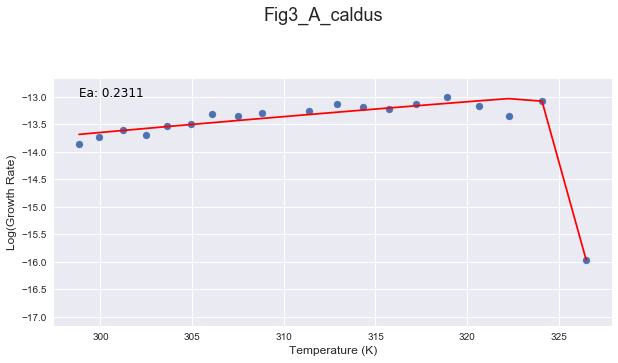

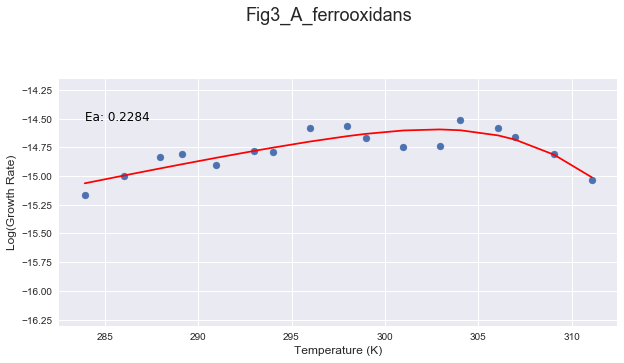

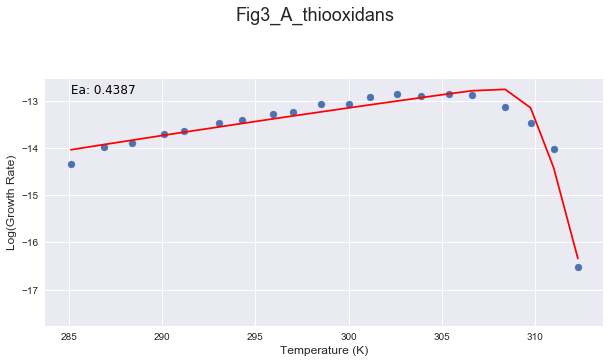

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

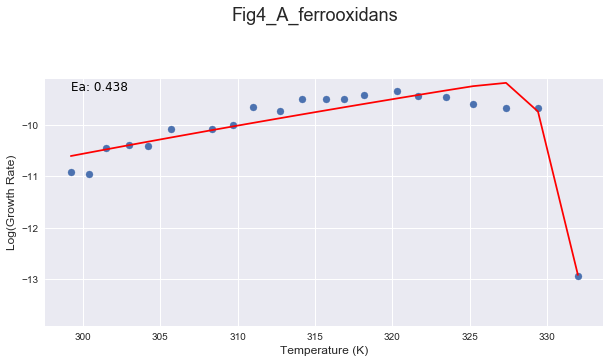

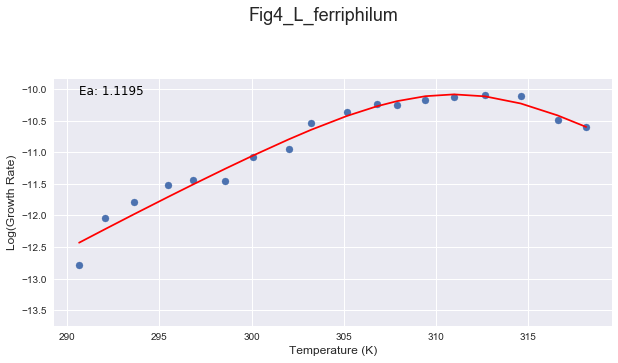

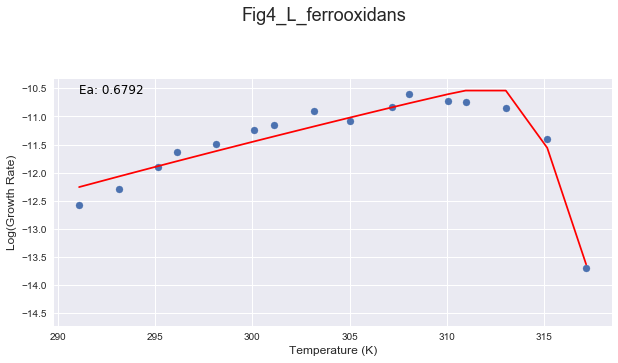

<Figure size 720x720 with 0 Axes>

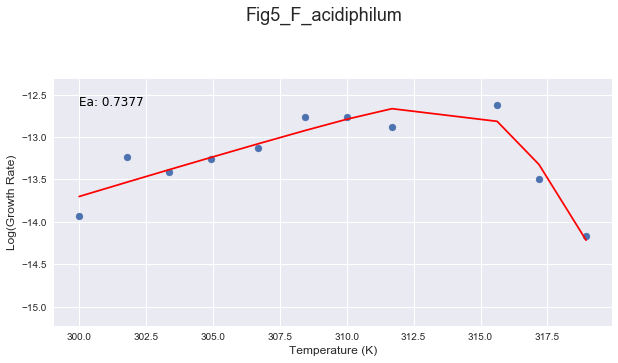

<Figure size 720x720 with 0 Axes>

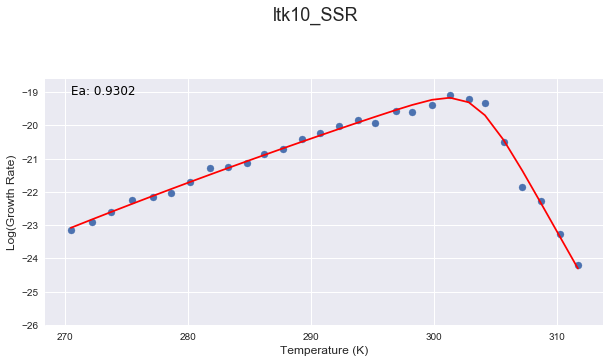

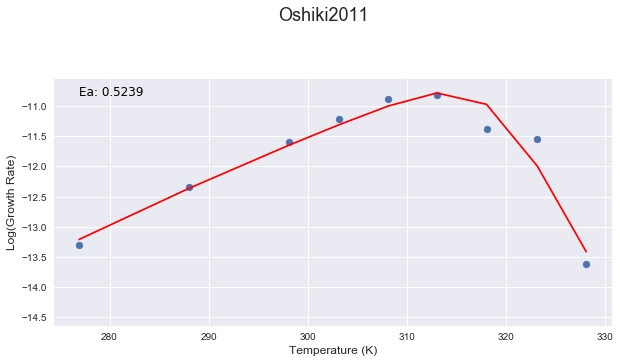

<Figure size 720x720 with 0 Axes>

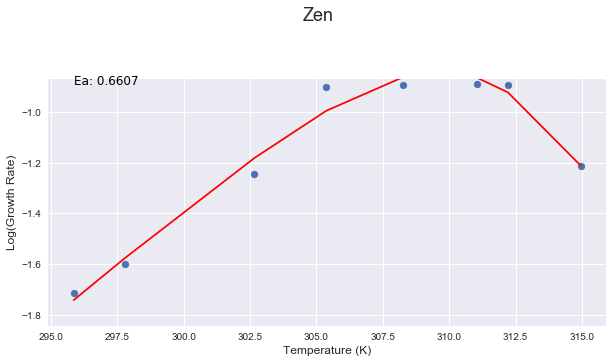

<Figure size 720x720 with 0 Axes>

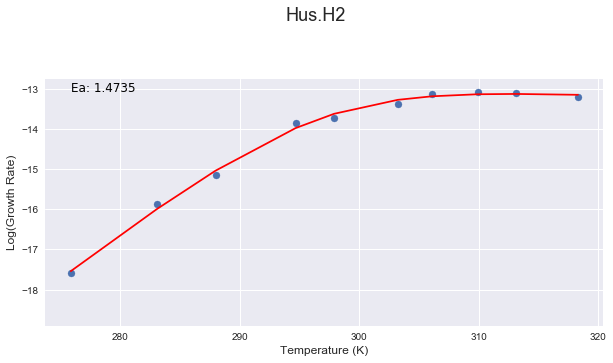

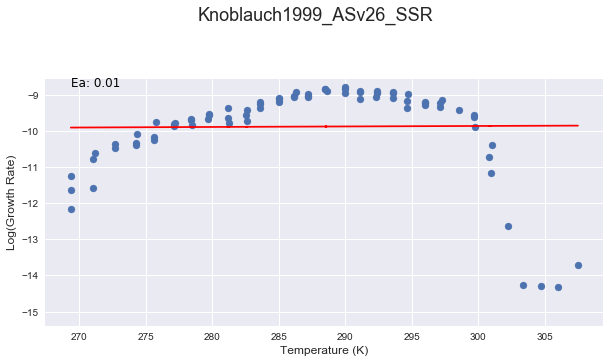

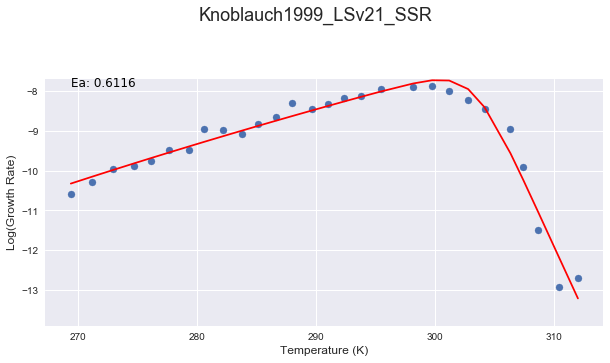

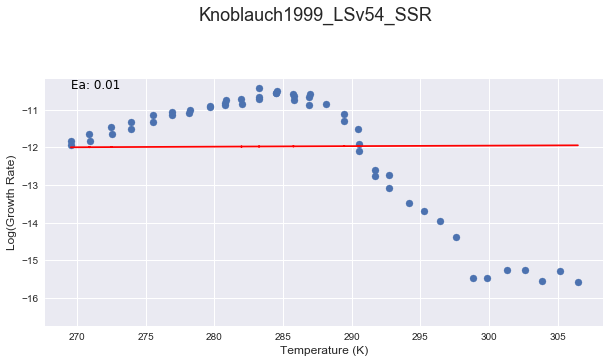

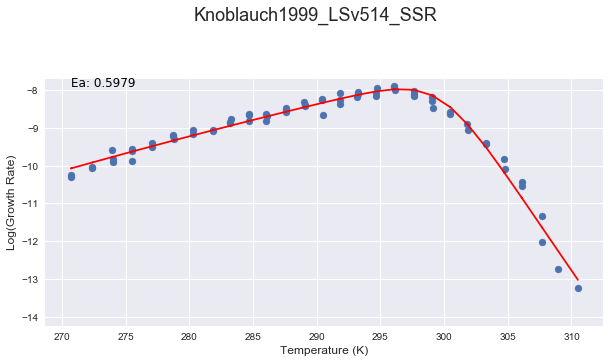

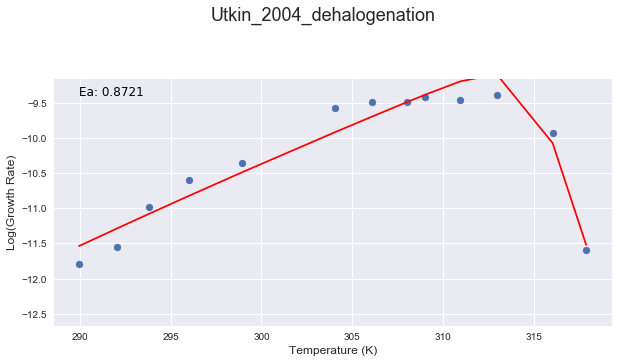

<Figure size 720x720 with 0 Axes>

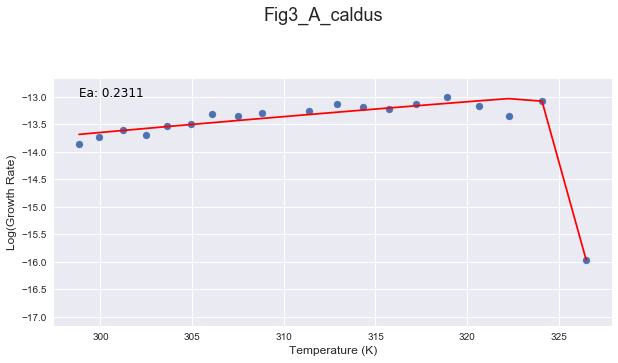

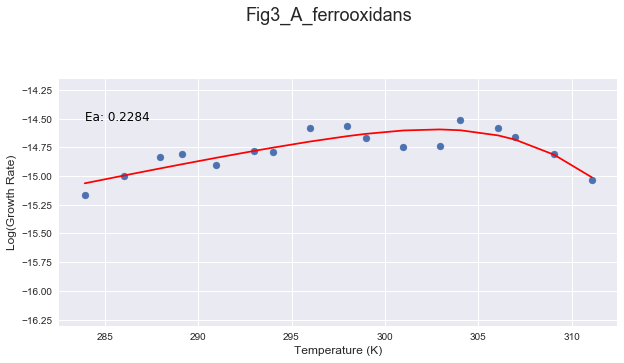

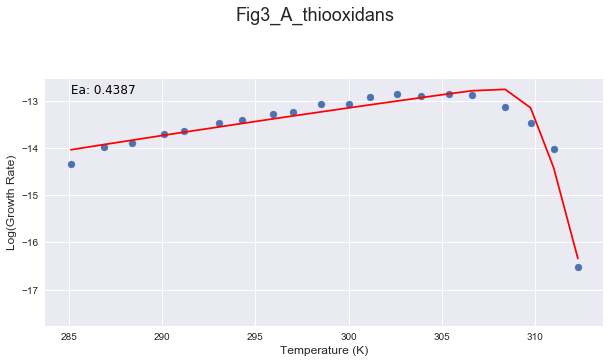

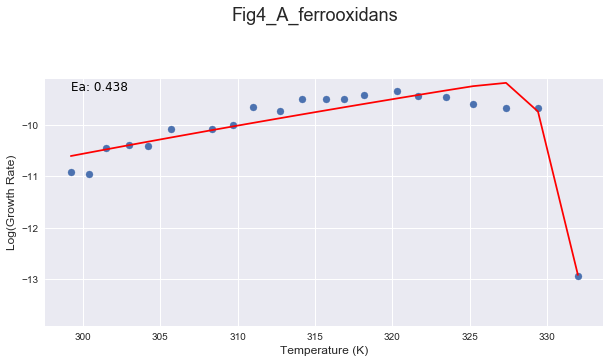

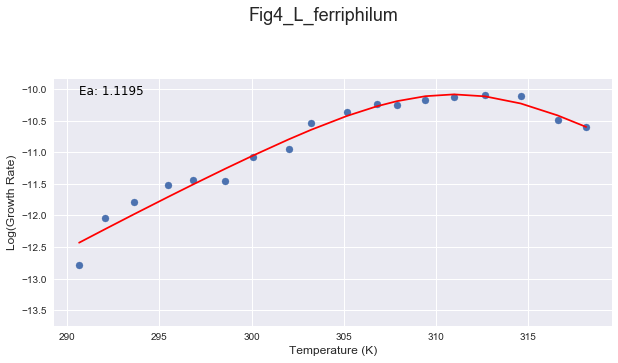

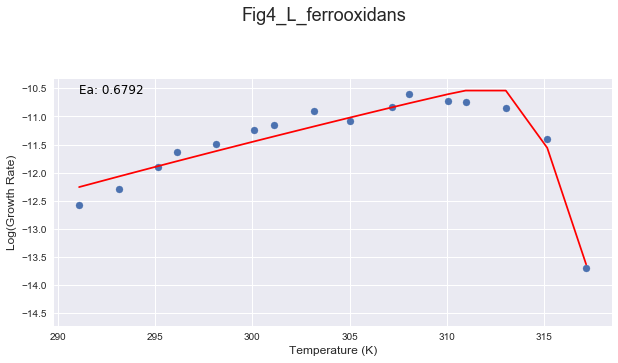

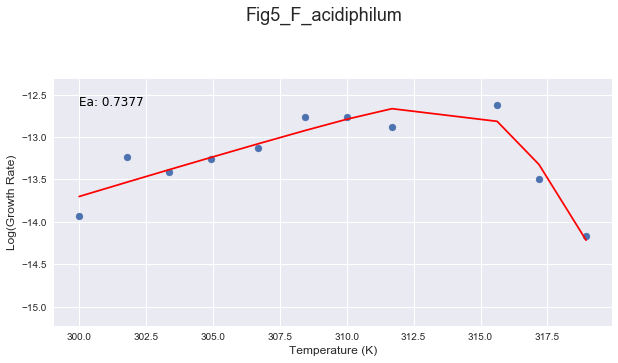

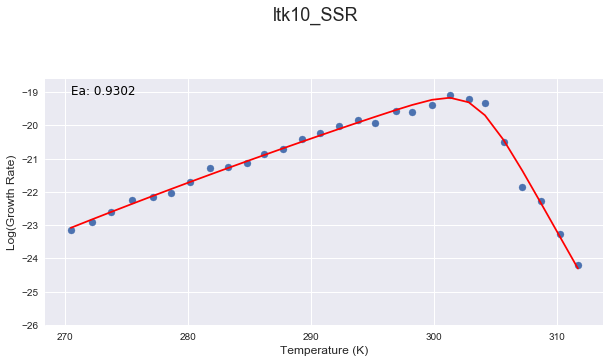

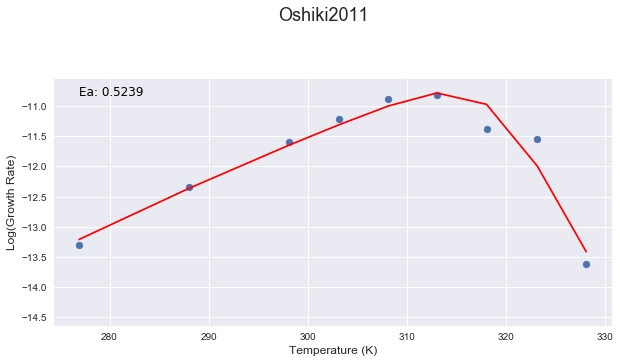

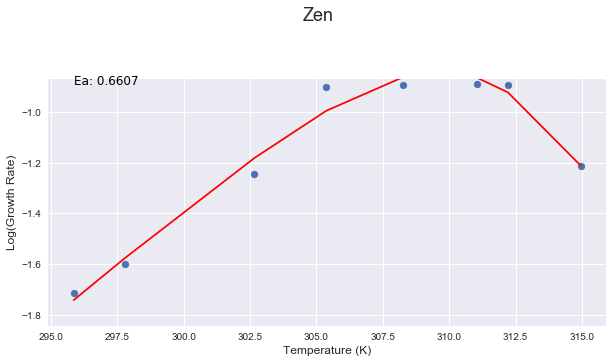

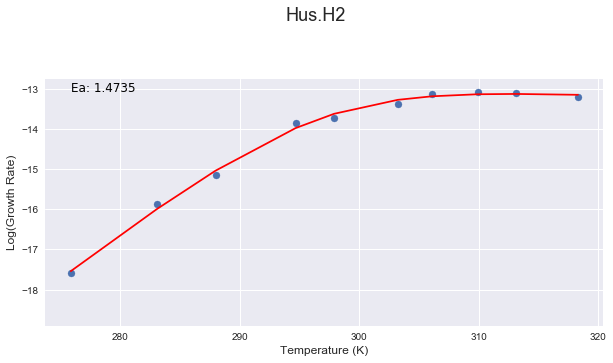

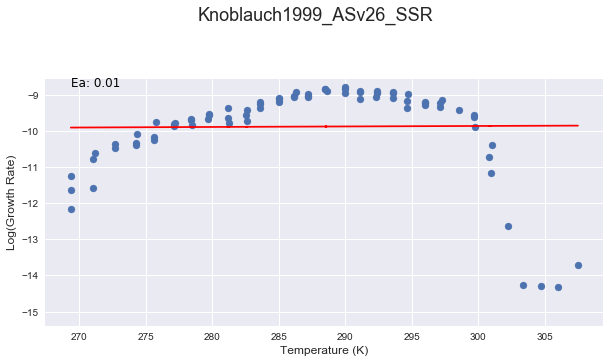

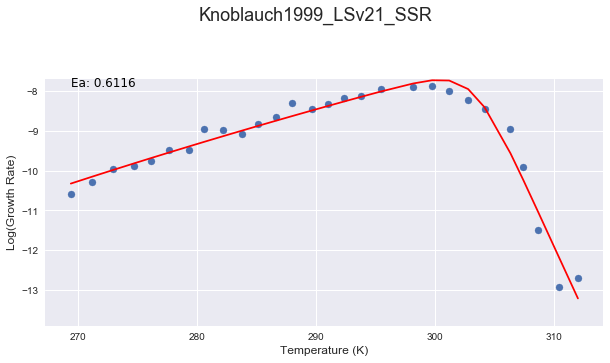

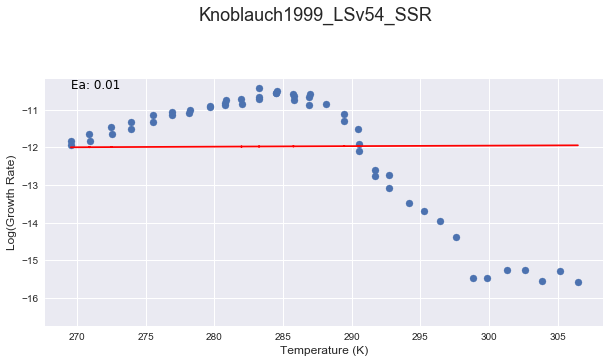

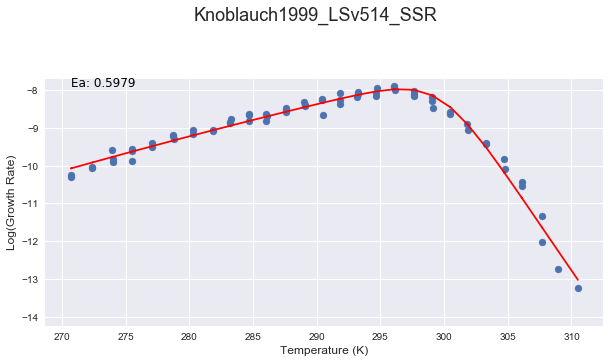

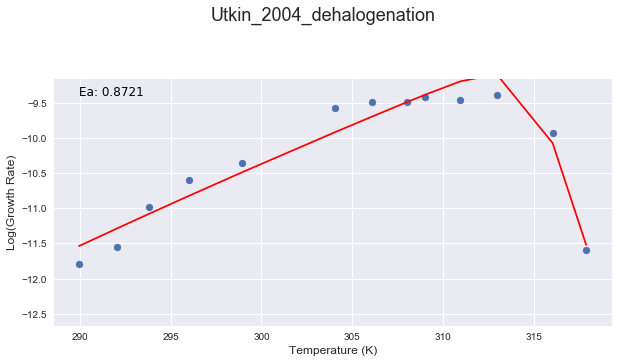

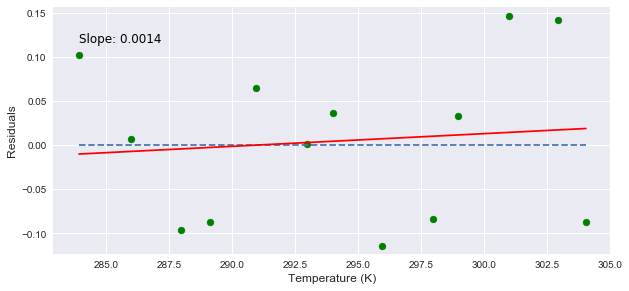

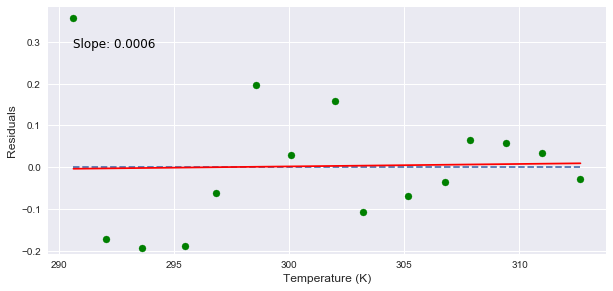

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

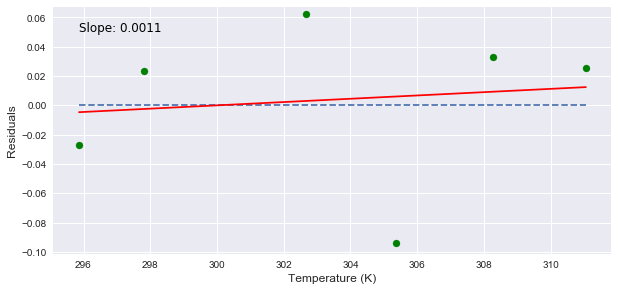

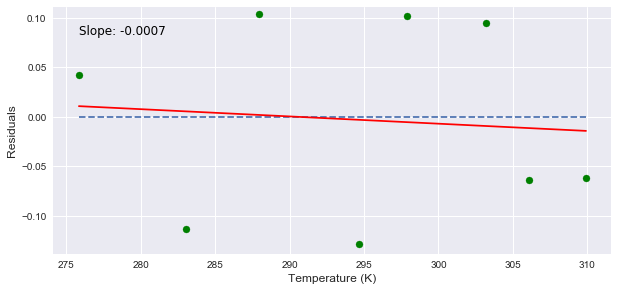

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

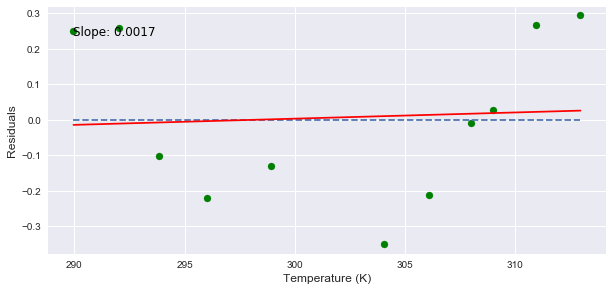

In [6]:
#### FILTERING BY ERROR AND PARAMS ####

print('No. pre-filtering by errors and params:' , str(len(ID_data_filter)))

#Filtering TPCs
TPC_filtered = []  #succesfully graphed TPCs
off_TPC = [] #unsuccesful TPCs

for ID in ID_dic:  
    fig = plt.figure(figsize=(10, 10))
    try:
        tpcs(ID)
        TPC_filtered.append(ID)
    except ValueError:
        off_TPC.append(ID)
        

#Filtering unreasonable parameter values
ID_params = {}
params_filtered = []

for ID in TPC_filtered:
    fig = plt.figure(figsize=(10, 10))    
    result = tpcs(ID)
    
    #obtain the optimized parameters
    params = result.valuesdict()
   
    #update ID_params dic
    new_k = ID
    opt_params = {}
    opt_params['Tpk'] = params['Tpk']
    opt_params['Ea'] = params['Ea']
    opt_params['Ed'] = params['Ed']
    opt_params['Bo'] = params['Bo']
    ID_params[new_k] = opt_params

for ID in ID_params.keys():
    opt_params = ID_params[ID]
    
    if opt_params['Tpk'] < 500 and opt_params['Ea'] < 3 and opt_params['Ed'] < 10:
        params_filtered.append(ID)
        
#Filtering Residual Graphs
res_filter = []
off_res = []

for ID in params_filtered:
    fig = plt.figure(figsize=(10, 10))
    try:
        
        residuals(ID)
        res_filter.append(ID)
    except TypeError:
            off_res.append(ID)
            
ID_post_filter = res_filter
print('No. post-filtering by errors and params:' , str(len(ID_post_filter)))

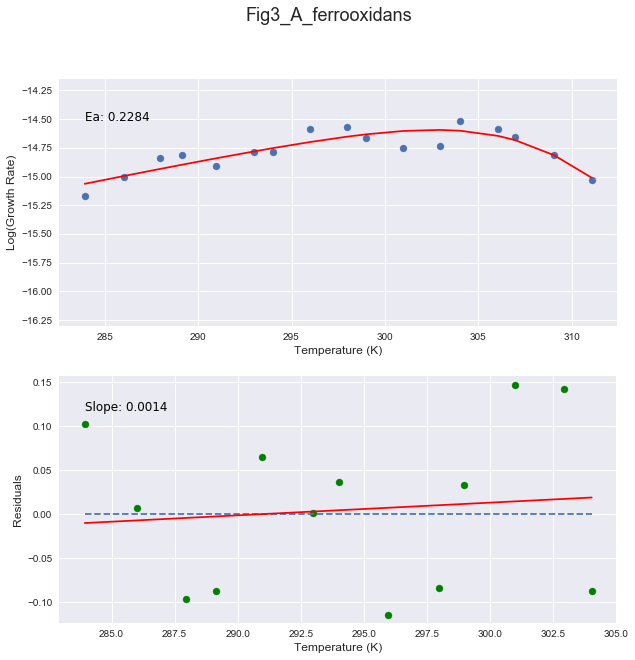

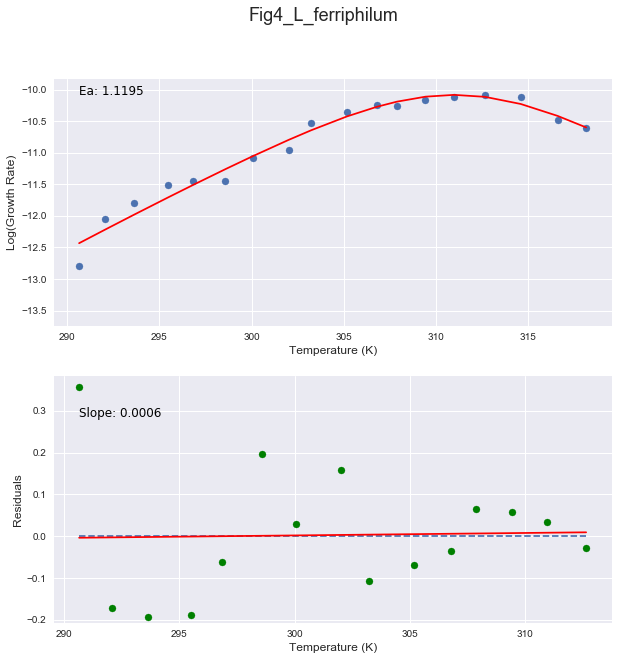

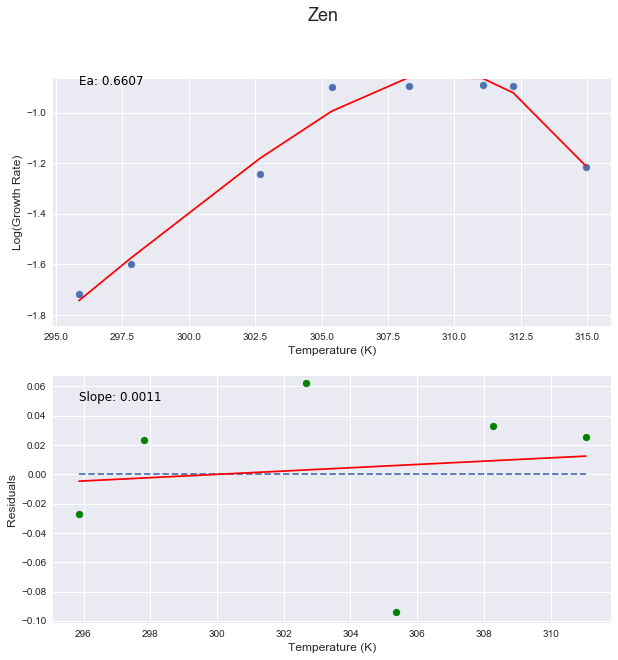

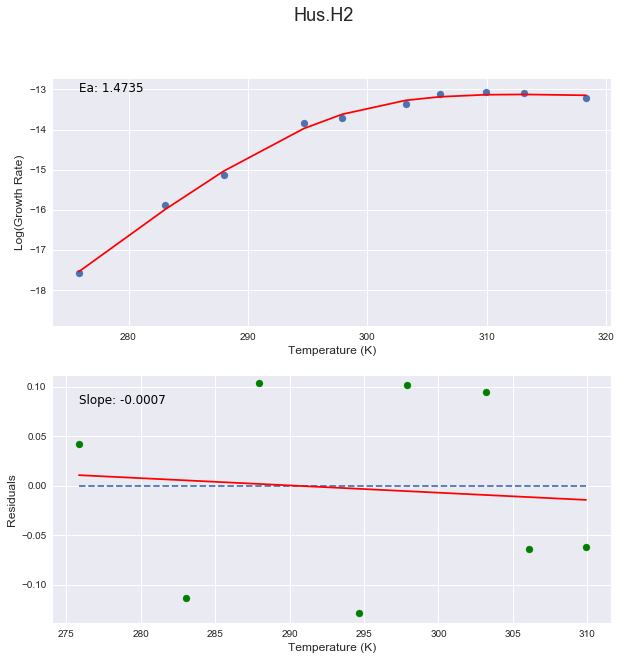

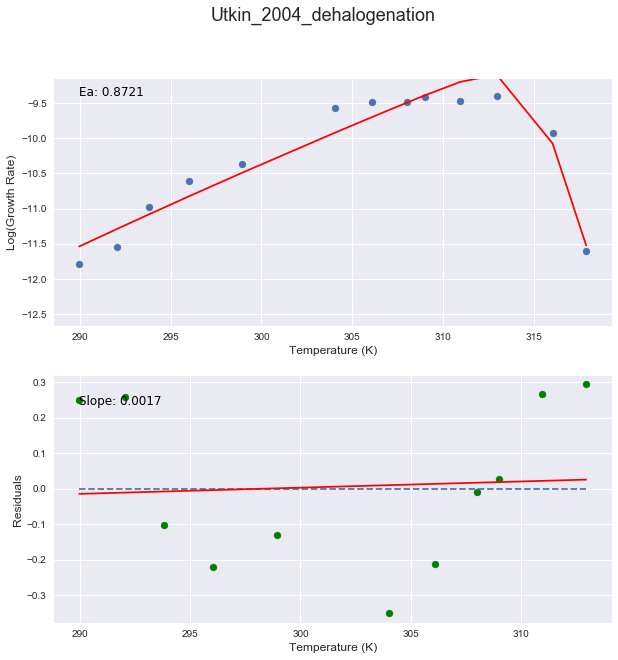

In [7]:
## CREATE PDF WITH GRAPHS ## 
with PdfPages('../Results/resmet_TPC&Residual_graphs.pdf') as pp:
    for i in range(0, len(res_filter)):
        fig = plt.figure(figsize=(10,10))
        ID = res_filter[i]             
        tpcs(ID)
        residuals(ID)
        pp.savefig(fig)
